In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='bright', font='sans-serif', font_scale=1.7, color_codes=True)

%matplotlib inline

# Some functions to generate random restless bandits

In [2]:
def should_we_print_the_policy(new_policy, best_policy, previous_policy, print_only_non_visited=False):
    """
    Returns True if the new_policy is not the previous policy AND differs from best_policy by at most 1 element
    """
    new_policy, best_policy, previous_policy = set(new_policy), set(best_policy), set(previous_policy)
    if print_only_non_visited:
        return best_policy.issubset(new_policy) and len(new_policy-best_policy) == 1
    else:
        return len(new_policy^best_policy)<=1 and new_policy != previous_policy
    
def name_of_policy(policy, n):
    if len(policy) == 0:
        return str(set(np.arange(n)+1))
    elif len(policy) == n:
        return r'$\emptyset$'
    else:
        return str(set(np.setdiff1d(np.arange(n), np.array(policy))+1))
    
def dense_probability_matrix(n):
    P = np.random.exponential(1,[n,n])
    for line in P:
        line /= sum(line)
    return P

class MarkovRewardProcess:
    def __init__(self, P, R):
        self.P = P
        self.R = R
        self.n = len(P)

    def average_reward(self):
        n = len(self.P)
        A = np.eye(n)
        A[1:,0] += 1
        A[:,1:] -= self.P[:,1:]
        return np.linalg.inv(A)@self.R
        
class RestlessBandit:
    def __init__(self, P0, P1, R0, R1):
        self.P0 = P0
        self.P1 = P1
        self.R0 = R0
        self.R1 = R1
        self.n = len(P0)
    
    @staticmethod
    def random_restless_bandit(n, seed=None):
        np.random.seed(seed)
        P0 = dense_probability_matrix(n)
        P1 = dense_probability_matrix(n)
        R0 = np.random.rand(n)
        R1 = np.random.rand(n)
        return RestlessBandit(P0, P1, R0, R1)

    def transition_matrix(self, activation_vector):
        n = len(self.P0)
        P = np.zeros(shape=(n,n))
        for i in range(n):
            P[i] = self.P0[i]*(1-activation_vector[i]) + self.P1[i]*activation_vector[i]
        return P

    def rewards(self, activation_vector):
        n = len(self.P0)
        R = np.zeros(shape=(n))
        for i in range(n):
            R[i] = self.R0[i]*(1-activation_vector[i]) + self.R1[i]*activation_vector[i]
        return R

    def average_reward(self, activation_vector, tax, output_biais=False):
        P = self.transition_matrix(activation_vector)
        R = self.rewards(activation_vector) - tax*np.array(activation_vector)
        if not output_biais:
            """Output the gain"""
            return MarkovRewardProcess(P, R).average_reward()[0]
        else:
            """Output the bias vector (gain at the 1st component)"""
            return MarkovRewardProcess(P, R).average_reward()
    
    def compute_reward_all_policies(self, xlim=[0, 1], output_biais=False):
        n = len(self.P0)
        names_of_policies = []
        rewards_of_policies = []
        for size in range(n+1):
            for rest_set in itertools.combinations(range(n), size):
                activation_vector = np.ones(n)
                for i in rest_set:
                    activation_vector[i] = 0
                r_left = self.average_reward(activation_vector, tax=xlim[0], output_biais=output_biais)
                r_right = self.average_reward(activation_vector, tax=xlim[1], output_biais=output_biais)
                rewards_of_policies.append([r_left, r_right])
                names_of_policies.append(rest_set)
        return names_of_policies, rewards_of_policies, xlim

    def illustrate_algorithm(self, xlim=[0, 1], ylim=[0,1], plot_optimal_gain=False, start_iter=1, algo_iteration=-1,
                             print_only_non_visited=False, is_indexable=True, legend_loc="best", plot_mu=False):
        """
        Plot a figure with all policies on it (+ the optimal value and/or the algorithm's iteration)
        
        Args:
        - is_indexable: boolean True if the bandit is known to be indexable, False if we do not know       
        """
        # We first compute the gain of all policies (including the optimal policy)
        names_of_policies, rewards_of_policies, _ = self.compute_reward_all_policies(xlim)
        x_range = np.linspace(xlim[0], xlim[1], 1000)
        y_range = np.array([np.interp(x_range, xlim, rewards) for rewards in rewards_of_policies])
        indices, policies, states = self.compute_optimal_intersection(y_range, names_of_policies, is_indexable)
                
        # here we plot the various curves
        current_policy, previous_policy='',''
        max_vertical_lines = 10000 if algo_iteration == -1 else algo_iteration
        col = 'b' if algo_iteration != -1 else 'r'
        for i in range(min(len(indices)-2, max_vertical_lines)):
            if i<len(indices)-2:
                plt.axvline(x_range[indices[i+1]], color=col, ls='--', lw=2)
                if plot_mu:
                    threshold = "$\mu^{}".format(i+start_iter)
                    threshold += "_{min}$"
                else:
                    threshold = "$\lambda_{}$".format(states[i]+1)
                plt.text(x_range[indices[i+1]], ylim[0], threshold ,color=col, va='bottom', fontsize='xx-large')
                if algo_iteration != -1:
                    plt.text(x_range[indices[i+1]], ylim[1], "$\sigma^{}={}$".format(i+start_iter, states[i]+1),color=col, va='top', fontsize='xx-large', rotation="vertical")
                active_set = "$\pi^{}$={}".format(i+start_iter, name_of_policy(policies[i], self.n))
            plt.text((x_range[indices[i]]+x_range[indices[i+1]])/2, ylim[1], active_set, ha='center', va='top', color=col, fontsize='xx-large', rotation="vertical")
            current_policy, previous_policy = policies[i], current_policy
        if i > self.n-start_iter-1:
            active_set = "$\pi^{}=\emptyset$".format(i+start_iter+1)
            plt.text((x_range[indices[i+1]]+xlim[1])/2, ylim[1], active_set, ha='center', va='top', color=col, fontsize='xx-large', rotation="vertical")
            
        # We plot the names of the policies
        for name,reward in zip(names_of_policies, rewards_of_policies):
            if plot_optimal_gain or should_we_print_the_policy(name, current_policy, previous_policy, print_only_non_visited): 
                plt.plot(xlim, reward, 'k:')
                for i in [0,1]:
                    plt.text(xlim[i], reward[i], name_of_policy(name, self.n), fontsize='large', ha='center', clip_on=True)
        
        # We plot either the optimal gain or the gain of the greedy algorithm
        if plot_optimal_gain:
            best_y_range = np.max(y_range, axis=0)
            plt.plot(x_range, best_y_range, 'r', label='Optimal Gain', lw=3)
        if algo_iteration != -1:
            xx = []
            yy = []
            for i in range(min(len(indices)-1, max_vertical_lines)):
                xx = np.append(xx, x_range[indices[i]:indices[i+1]])
                yy = np.append(yy, y_range[names_of_policies.index(policies[i])][indices[i]:indices[i+1]])
            plt.plot(xx, yy, color='b', ls='-.', label='Algorithm', lw=3)

        plt.xlabel('Penalty')
        plt.ylabel('Gain')
        plt.legend(loc=legend_loc)
        plt.ylim(ylim)
        return [x_range[indices[i+1]] for i in range(len(states))], states

    def compute_optimal_intersection(self, yrange, names_of_policies, is_indexable=True):
        """
        Compute all optimal policies and their penalty interval of optimality.
        This function might be buggy when there are two states that change states at the same time.
        
        Args:
        - is_indexable: boolean True if the bandit is known to be indexable, False if we do not know
        """
        number_of_policies,  number_of_timesteps = yrange.shape
        best_policies = [np.argmax(yrange[:,0])]
        indices, indices_states = [0], []
        for t in range(1, number_of_timesteps):
            for policy in range(number_of_policies):
                if yrange[policy][t] > yrange[best_policies[-1]][t]:
                    if (is_indexable and
                        set(names_of_policies[best_policies[-1]]).issubset(set(names_of_policies[policy]))):
                        # if the bandit is indexable, the policies increase through inclusion
                        indices.append(t)
                        state_changes = tuple(set(names_of_policies[policy])-set(names_of_policies[best_policies[-1]]))
                        indices_states.append(state_changes[0])
                        best_policies.append(policy)
                    if not is_indexable:
                        # if is_indexable is False, compute all possible optimal policies
                        indices.append(t)
                        if len(names_of_policies[policy]) > len(names_of_policies[best_policies[-1]]):
                            state_changes = tuple(set(names_of_policies[policy])-set(names_of_policies[best_policies[-1]]))
                        elif len(names_of_policies[policy]) < len(names_of_policies[best_policies[-1]]):
                            state_changes = tuple(set(names_of_policies[best_policies[-1]])-set(names_of_policies[policy]))
                        indices_states.append(state_changes[0])
                        best_policies.append(policy)
        best_policies.append(best_policies[-1])
        best_policies = [names_of_policies[p] for p in best_policies]
        indices.append(t-1)
        #print(best_policies, indices_states)
        return indices, best_policies, indices_states
                
def diff_policy(policy1, policy2):
    for i in policy1:
        if i not in policy2:
            return i
    return ''

## Non-indexable Problem

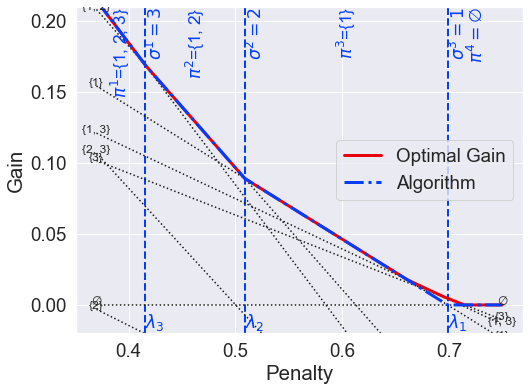

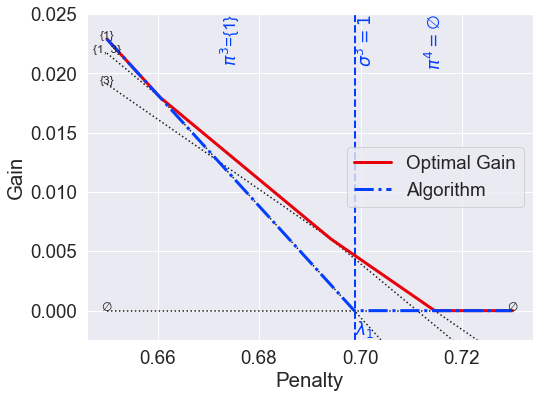

In [3]:
P0 = np.array([[0.00465687, 0.7929594 , 0.20238373],
               [0.02739644, 0.55824832, 0.41435524],
               [0.73586324, 0.24886017, 0.01527659]])
P1 = np.array([[0.71784665, 0.25414521, 0.02800813],
               [0.34733914, 0.09707586, 0.555585  ],
               [0.01520433, 0.95578687, 0.0290088 ]])
R1 = np.array([0.6987786948572177, 0.36172296008958293, 0.7146162453892186])
R0 = np.array([0, 0, 0])
bandit1 = RestlessBandit(P0, P1, R0, R1)

plt.figure(figsize=(8, 6))
bandit1.illustrate_algorithm([0.37,0.75], [-0.02,.21], plot_optimal_gain=True, plot_mu=False, algo_iteration=4, legend_loc="center right")
plt.savefig('../figures/illustrate_non_idx1.pdf', bbox_inches='tight')

plt.figure(figsize=(8, 6))
bandit1.illustrate_algorithm([0.65,0.73], [-0.0025,.025], plot_optimal_gain=True, start_iter=3, algo_iteration=4, plot_mu=False, legend_loc="center right")
plt.savefig('../figures/illustrate_non_idx2.pdf', bbox_inches='tight')

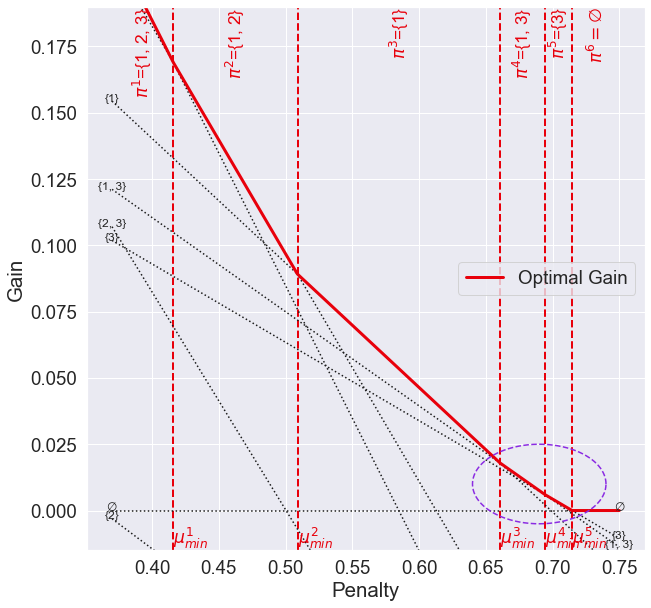

In [4]:
plt.figure(figsize=(10, 10))
#print(bandit1.illustrate_algorithm([0.35,0.75], [-0.01,.2], plot_optimal_gain=True, is_indexable=False, legend_loc="center right"))
bandit1.illustrate_algorithm([0.37,0.75], [-0.015,.19], plot_optimal_gain=True, is_indexable=False, legend_loc="center right", plot_mu=True)
t = np.linspace(0, 2*np.pi, 1000)
plt.plot(0.69+0.05*np.cos(t), 0.01+0.015*np.sin(t),'m--')
plt.savefig('../figures/illustrate_non_idx3.pdf', bbox_inches='tight')

# Indexable but not PCL-indexable example

([0.2994994994994995, 0.7024024024024025, 0.8033033033033032], [0, 2, 1])

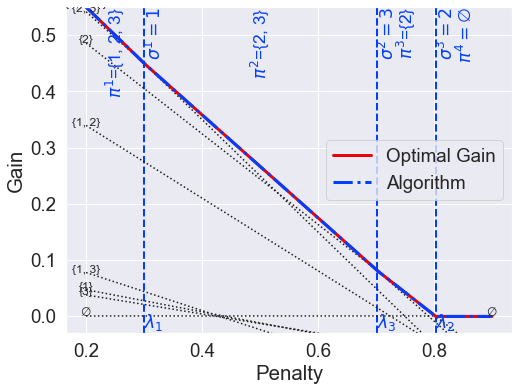

In [5]:
P0 = np.array([[0.3629, 0.5028, 0.1343],
               [0.0823, 0.7534, 0.1643],
               [0.2460, 0.0294, 0.7246]])
P1 = np.array([[0.1719, 0.1749, 0.6532],
               [0.0547, 0.9317, 0.0136],
               [0.1547, 0.6271, 0.2182]])
R1 = np.array([0.44138, 0.8033, 0.4257])
R0 = np.array([0, 0, 0])
bandit1 = RestlessBandit(P0, P1, R0, R1)

plt.figure(figsize=(8, 6))
bandit1.illustrate_algorithm([0.2,0.9], [-0.03,0.55], plot_optimal_gain=True, algo_iteration=4, legend_loc='center right')
#plt.savefig('../figures/illustrate_non_idx1.pdf', bbox_inches='tight')

# Indexable example

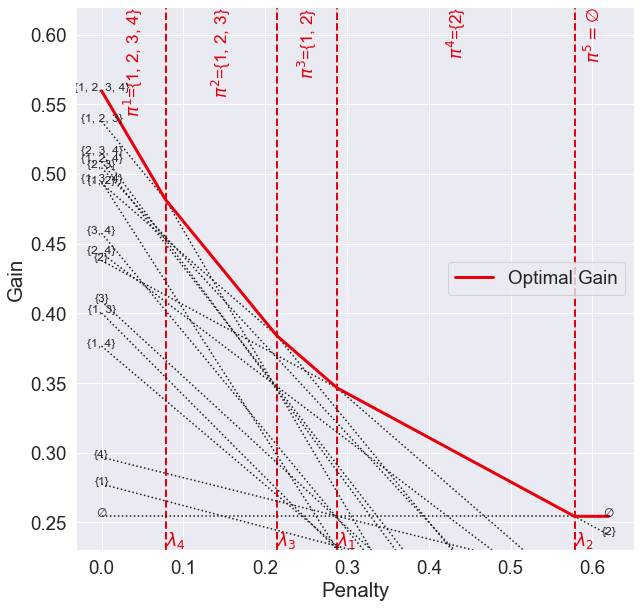

In [6]:
bandit = RestlessBandit.random_restless_bandit(4, seed=4)
plt.figure(figsize=(10, 10))
bandit.illustrate_algorithm([0.00,0.62], [0.23,.62], plot_optimal_gain=True, legend_loc="center right")
plt.savefig('../figures/illustrate_vf.pdf', bbox_inches='tight')

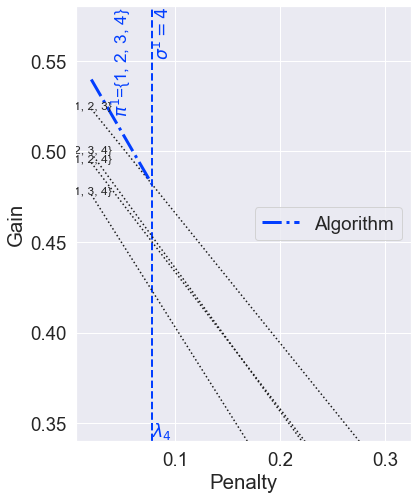

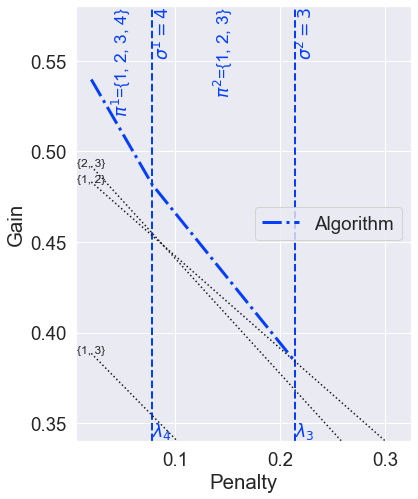

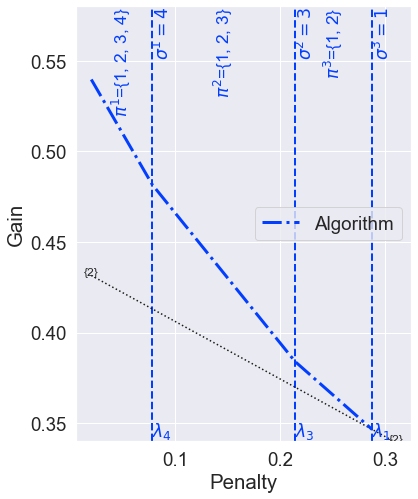

In [7]:
for algo_iteration in [1, 2, 3]:
    plt.figure(figsize=(6, 8))
    bandit.illustrate_algorithm([0.02,0.31], [0.34,.58], algo_iteration=algo_iteration, print_only_non_visited=True, legend_loc="center right")
    plt.savefig('../figures/illustrate_vf_{}.pdf'.format(algo_iteration), bbox_inches='tight')